In [1]:
import cv2
import glob
import os
import torch
import math
import re

import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torch_data
import torchvision as tv
import numpy as np
import matplotlib.pyplot as plt

from lpips import LPIPS
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

In [2]:
class Dataset(torch_data.Dataset):
    def __init__(self, img_size, train=True, transform=None):
        self.transform = transform
        self.img_size = img_size

        self.elements = []
        # self.elements.extend(glob.glob("data/laion400M/00001/img/*"))
        self.elements.extend(glob.glob("data/scrolller/img/*"))
        self.elements.extend(glob.glob("/mnt/data/youtube/img/*"))
        self.elements = sorted(self.elements)

        n_train = int(len(self.elements) * 0.8)
        if train:
            self.elements = self.elements[:n_train]
        else:
            self.elements = self.elements[n_train:]
    
    def __len__(self):
        return len(self.elements)

    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()

        filename = self.elements[idx]
        img = cv2.imread(filename)

        try:
            img[:, :, [0, 1, 2]] = img[:, :, [2, 1, 0]]
        except Exception as e:
            print()
            print("REMOVE", filename, e)
            os.remove(filename)

        h, w, c = img.shape
        if h < w:
            idx = np.random.randint(0, w - h)
            idx_lower = int(idx/2)
            img = img[:, idx_lower:idx_lower + h]
        if w < h:
            idx = np.random.randint(0, h - w)
            idx_lower = int(idx / 2)
            img = img[idx_lower:idx_lower + w]

        img = cv2.resize(img, (self.img_size, self.img_size))
        img = img.transpose(2, 0, 1)
        img = ((img / 256) * 2) - 1
        img = np.asarray([img], dtype=np.float32)
        img = torch.from_numpy(img)

        rdx = np.random.random()
        BS, C, H, W = img.shape
        f = "ORIG"
        # if rdx < 0.33:
        #     f = "2x"
        #     img = F.interpolate(img, (H // 2, W // 2), mode="bilinear")
        #     img = F.interpolate(img, (H, W), mode="bilinear")
        # elif rdx < 0.66:
        #     f = "4x"
        #     img = F.interpolate(img, (H // 4, W // 4), mode="bilinear")
        #     img = F.interpolate(img, (H, W), mode="bilinear")
        
        element = dict()
        element["img"] = img[0]
        element["f"] = f
        element["filename"] = filename
        
        if self.transform:
            element = self.transform(element)

        return element

In [3]:
BATCH_SIZE = 6
BATCH_SUM = 8
IMG_SIZE = 256
DEVICE = "cuda"
LR = 1e-7
WEIGHT_DECAY = 0
N_EPOCHS = 100
FILE_NAME_AUTOENCODER = f"weights/autoencoder_{IMG_SIZE}.pth"
FILE_NAME_ENCODER = f"weights/encoder_{IMG_SIZE}.pth"
FILE_NAME_DECODER = f"weights/decoder_{IMG_SIZE}.pth"
FILE_NAME_REFINER = f"weights/refiner_{IMG_SIZE}.pth"
GRAD_CLIP = 1.0

In [4]:
train_dataset = Dataset(IMG_SIZE, train=True)
test_dataset = Dataset(IMG_SIZE, train=False)
train_loader = torch_data.DataLoader(train_dataset, shuffle=True, pin_memory=True, num_workers=16, batch_size=BATCH_SIZE)
test_loader = torch_data.DataLoader(test_dataset, shuffle=True, pin_memory=True, num_workers=16, batch_size=BATCH_SIZE)
print(len(train_dataset))
print(len(test_dataset))
print(len(train_dataset) + len(test_dataset))

1310018
327505
1637523


In [5]:
# with torch.no_grad():
#     encoder = Encoder().to(DEVICE)
#     encoder.load_state_dict(torch.load(FILE_NAME_ENCODER))
    
#     BASE_PATH_LATENT = "/mnt/data/youtube/latent"
#     BASE_PATH_IMG = "/mnt/data/youtube/img_latent"
#     for i, batch in enumerate(train_loader):
#         print(f"\r{i}|{len(train_loader)}", end="")
    
#         img = batch["img"].to(DEVICE)
#         bs, c, h, w = img.shape
#         noise = torch.randn([bs, 4, h // 8, w // 8]).to(DEVICE)
#         latent = encoder(img, noise)
#         latent = latent.detach().cpu().numpy().transpose(0, 2, 3, 1)
#         img = ((img.detach().cpu().numpy().transpose(0, 2, 3, 1) + 1) / 2) * 256
#         img[:, :, [0, 1, 2]] = img[:, :, [2, 1, 0]]
    
#         filenames = batch["filename"]
        
#         for j in range(len(filenames)):
#             filename = filenames[j]
#             filename = filename.split("/")[-1]
#             filename_base = filename.split(".")[0]
            
#             filename = os.path.join(BASE_PATH_LATENT, f"{filename_base}.png")
#             with open(filename, "wb") as f:
#                 np.save(f, latent[j])
        
#             filename = os.path.join(BASE_PATH_IMG, f"{filename_base}.png")
#             cv2.imwrite(filename, img[j])

In [17]:
def criterion(pred, img):
    loss_mse = nn.MSELoss()(pred, img)
    loss_lpips = torch.mean(lpips(pred, img)) / 4
    
    loss = 0
    loss += loss_mse
    loss += loss_lpips
    return loss
def train():
    model.train()

    ud = []
    color = np.repeat(np.linspace(50, 255, 240, dtype=int)[:, None], 3, -1).tolist()
    iterator = iter(train_loader)
    N = int(np.floor(len(train_loader) / BATCH_SUM))
    sum_loss = 0
    count = 0
    for i in range(N):
        for j in range(BATCH_SUM):
            batch = next(iterator)
            
            img = batch["img"].to(DEVICE)
            
            bs, c, h, w = img.shape
            noise = torch.randn([bs, 4, h // 8, w // 8]).to(DEVICE)

            if REFINE:
                pred, latent = model(img, noise, REFINE)
            else:
                pred, latent = model(img, noise)
            
            loss = criterion(pred, img)
            loss = loss / BATCH_SUM
            scaler.scale(loss).backward()

            sum_loss += loss.item()
            count += 1
            
            print(f"\r{i + 1:06}/{N:06} | {j + 1:03}/{BATCH_SUM:03} loss: {(sum_loss / count) * BATCH_SUM}", end="")

            with torch.no_grad():
                ud.append([((LR*p.grad).std() / p.data.std()).log10().item() for p in model.parameters()])
        
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)

        if ((i + 1) % 5) == 0:
            torch.save(model.state_dict(), FILE_NAME_AUTOENCODER)
            torch.save(model.encoder.state_dict(), FILE_NAME_ENCODER)
            torch.save(model.decoder.state_dict(), FILE_NAME_DECODER)
            if REFINE:
                torch.save(model.refiner.state_dict(), FILE_NAME_REFINER)
            sum_loss = 0
            count = 0

            indices = np.argsort(ud)[0][::-1]
            parameters = [(name, p) for name, p in model.named_parameters()]
            count = 0
            
            plt.figure(figsize=(20, 4))
            legends = []
            for i in indices:

                if count == 10:
                    break
                
                name, p = parameters[i]

                if "groupnorm" in name:
                    continue

                count += 1
                
                plt.plot([ud[j][i] for j in range(len(ud))])
                legends.append('param %d %s' % (i, name))
            plt.plot([0, len(ud)], [-3, -3], 'k')
            plt.legend(legends)
            plt.show()

            show(N=1, M=1)
            
            print()

        # if ((i + 1) % 25) == 0:
        #     show(N=1, M=1)
    
    print()
def show(N=1, M=1):
    model.eval()

    batch = next(iter(test_loader))
    
    img = batch["img"].to(DEVICE)
    f = batch["f"]

    bs, c, h, w = img.shape
    noise = torch.zeros([bs, 4, h // 8, w // 8]).to(DEVICE)

    with torch.no_grad():
        if REFINE:
            pred, latent = model(img, noise, REFINE)
        else:
            pred, latent = model(img, noise)

    latent = F.interpolate(latent, (IMG_SIZE, IMG_SIZE), mode="bilinear")
    
    img_np = img.detach().cpu().numpy()
    latent_np  = latent.detach().cpu().numpy()
    pred_np  = pred.detach().cpu().numpy()

    H = 20
    W = int((H / 2.5) * (N / M))
    fig, axes = plt.subplots(N, M, figsize=(H, W))

    if N == 1 and M == 1:
        axes = [axes]
    elif N == 1:
        axes = [axes]
    if M == 1:
        axes = [axes]               
                             
    for n in range(N):
        for m in range(M):
            idx = n * M + m
            
            img_ = img_np [idx]
            img_ = (img_ + 1) / 2

            latent_ = latent_np [idx]
            latent_ = latent_ - latent_.min()
            latent_ = latent_ / latent_.max()
            latent_ = latent_[:3]
            
            pred_ = pred_np [idx]
            pred_ = (pred_ + 1) / 2

            loss_mse = ((pred[0:1] - img[0:1])**2).sqrt().mean()
            loss_lpips = (lpips(pred[0:1], img[0:1])).mean() / 4
            
            img_ = np.concatenate([img_, pred_, latent_], axis=-1).transpose(1, 2, 0)
            axes[n][m].imshow(img_)
            axes[n][m].set_title(f"{f[0]}, mse: {loss_mse:0.5f}, lpips: {loss_lpips:0.5f}")
    plt.show()
def estimate_compression():
    model.eval()
    batch = next(iter(train_loader))
    img = batch["img"].to(DEVICE)
    
    bs, c, h, w = img.shape
    noise = torch.zeros([bs, 4, h // 8, w // 8]).to(DEVICE)

    with torch.no_grad():
        pred, latent = model(img, noise)
    
    img = img.detach().cpu().numpy()[0].transpose(1, 2, 0)
    latent = latent.detach().cpu().numpy()[0].transpose(1, 2, 0)

    img_shape = len(img.reshape(-1))
    latent_shape = len(latent.reshape(-1))
    
    filename_img = "data/img.jpg"
    cv2.imwrite(filename_img, img)
    file_stats_img = os.stat(filename_img)
    img_size = file_stats_img.st_size

    filename_latent = "data/latent.jpg"
    cv2.imwrite(filename_latent, latent)
    file_stats_latent = os.stat(filename_latent)
    latent_size = file_stats_latent.st_size

    print(f"Compression shape: {int(img_shape / latent_shape)}")
    print(f"Compression bytes: {int(img_size / latent_size)}")
def eval(loader):
    sum_loss = 0
    count = 0
    for i, batch in enumerate(loader):
        img = batch["img"].to(DEVICE)
        
        bs, c, h, w = img.shape
        noise = torch.zeros([bs, 4, h // 8, w // 8]).to(DEVICE)

        with torch.no_grad():
            pred, latent = model(img, noise)
        
        loss = criterion(pred, img)
        sum_loss += loss.item()
        count += 1
        
        print(f"\r{i + 1:06}/{len(loader):06} loss: {sum_loss / count}", end="")
    print()

In [7]:
class SelfAttention(nn.Sequential):
    def __init__(self, n_heads, d_embed, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        self.in_proj = nn.Linear(d_embed, 3 * d_embed, bias=in_proj_bias)
        self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)
        self.n_heads = n_heads
        self.d_head = d_embed // n_heads

        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, x, causal_mask=False):
        input_shape = x.shape
        batch_size, sequence_length, d_embed = input_shape
        interim_shape = (batch_size, sequence_length, self.n_heads, self.d_head)

        q, k, v = self.in_proj(x).chunk(3, dim=-1)

        q = q.view(interim_shape).transpose(1, 2)
        k = k.view(interim_shape).transpose(1, 2)
        v = v.view(interim_shape).transpose(1, 2)

        weight = q @ k.transpose(-1, -2)
        if causal_mask:
            mask = torch.ones_like(weight, dtype=torch.bool).triu(1)
            weight.masked_fill_(mask, -torch.inf)
        weight /= math.sqrt(self.d_head)
        weight = F.softmax(weight, dim=-1)

        output = weight @ v
        output = output.transpose(1, 2)
        output = output.reshape(input_shape)
        output = self.out_proj(output)
        return output
class AttentionBlock(nn.Sequential):
    
    def __init__(self, channels):
        super().__init__()
        self.groupnorm = nn.GroupNorm(32, channels)
        self.attention = SelfAttention(1, channels)

        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    
    def forward(self, x):
        residue = x
        x = self.groupnorm(x)

        n, c, h, w = x.shape
        x = x.view((n, c, h * w))
        x = x.transpose(-1, -2)
        x = self.attention(x)
        x = x.transpose(-1, -2)
        x = x.view((n, c, h, w))

        x += residue
        return x
class ResidualBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.groupnorm_1 = nn.GroupNorm(32, in_channels)
        self.conv_1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

        self.groupnorm_2 = nn.GroupNorm(32, out_channels)
        self.conv_2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        if in_channels == out_channels:
            self.residual_layer = nn.Identity()
        else:
            self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)

        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    
    def forward(self, x):
        residue = x

        x = self.groupnorm_1(x)
        x = F.silu(x)
        x = self.conv_1(x)

        x = self.groupnorm_2(x)
        x = F.silu(x)
        x = self.conv_2(x)

        return x + self.residual_layer(residue)
class Encoder(nn.Sequential):
    def __init__(self):
        super().__init__(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            ResidualBlock(128, 128),
            ResidualBlock(128, 128),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=0),
            ResidualBlock(128, 256),
            ResidualBlock(256, 256),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=0),
            ResidualBlock(256, 512),
            ResidualBlock(512, 512),
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=0),
            ResidualBlock(512, 512),
            ResidualBlock(512, 512),
            ResidualBlock(512, 512),
            AttentionBlock(512),
            ResidualBlock(512, 512),
            nn.GroupNorm(32, 512),
            nn.SiLU(),
            nn.Conv2d(512, 8, kernel_size=3, padding=1),
            nn.Conv2d(8, 8, kernel_size=1, padding=0),
        )

        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, x, noise):
        for module in self:
            if getattr(module, 'stride', None) == (2, 2):  # Padding at downsampling should be asymmetric (see #8)
                x = F.pad(x, (0, 1, 0, 1))
            x = module(x)

        mean, log_variance = torch.chunk(x, 2, dim=1)
        log_variance = torch.clamp(log_variance, -30, 20)
        variance = log_variance.exp()
        stdev = variance.sqrt()
        x = mean + stdev * noise

        x *= 0.18215
        return x
class Decoder(nn.Sequential):
    def __init__(self):
        super().__init__(
            nn.Conv2d(4, 4, kernel_size=1, padding=0),
            nn.Conv2d(4, 512, kernel_size=3, padding=1),
            ResidualBlock(512, 512),
            AttentionBlock(512),
            ResidualBlock(512, 512),
            ResidualBlock(512, 512),
            ResidualBlock(512, 512),
            ResidualBlock(512, 512),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            ResidualBlock(512, 512),
            ResidualBlock(512, 512),
            ResidualBlock(512, 512),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            ResidualBlock(512, 256),
            ResidualBlock(256, 256),
            ResidualBlock(256, 256),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            ResidualBlock(256, 128),
            ResidualBlock(128, 128),
            ResidualBlock(128, 128),
            nn.GroupNorm(32, 128),
            nn.SiLU(),
            nn.Conv2d(128, 3, kernel_size=3, padding=1),
        )

        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, x):
        x /= 0.18215
        for module in self:
            x = module(x)
        return x
class Refiner(nn.Sequential):
    def __init__(self):
        super().__init__(
            nn.Conv2d(3, 128, kernel_size=2, padding=1),
            ResidualBlock(128, 128),
            ResidualBlock(128, 128),
            nn.GroupNorm(32, 128),
            nn.SiLU(),
            nn.Conv2d(128, 3, kernel_size=2, padding=0),
        )

    def forward(self, x):
        for module in self:
            x = module(x)
        return x
class Model(nn.Sequential):
    def __init__(self):
        super().__init__()

        self.encoder = Encoder()
        self.decoder = Decoder()
        self.refiner = None

        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, x, noise, refine=False):

        latent = self.encoder(x, noise)
        x = self.decoder(latent)
        x = F.tanh(x)

        if refine:
            x = self.refiner(x)
            x = F.tanh(x)
        
        return x, latent

In [8]:
REFINE = False
model = Model().to(DEVICE)
#model.encoder.load_state_dict(torch.load(FILE_NAME_ENCODER))
#model.decoder.load_state_dict(torch.load(FILE_NAME_DECODER))
lpips = LPIPS().eval().to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
for p in lpips.parameters():
    if p.requires_grad:
        p.requires_grad = False
scaler = torch.cuda.amp.GradScaler()
print(f"model: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}".replace(",", "."))
print(f"model.encoder: {sum(p.numel() for p in model.encoder.parameters() if p.requires_grad):,}".replace(",", "."))
print(f"model.decoder: {sum(p.numel() for p in model.decoder.parameters() if p.requires_grad):,}".replace(",", "."))
print(f"lpips: {sum(p.numel() for p in lpips.parameters() if p.requires_grad):,}".replace(",", "."))

# REFINE = True
# model = Model().eval().to(DEVICE)
# model.encoder.load_state_dict(torch.load(FILE_NAME_ENCODER))
# model.decoder.load_state_dict(torch.load(FILE_NAME_DECODER))
# lpips = LPIPS().eval().to(DEVICE)
# refiner = Refiner().to(DEVICE)
# model.refiner = refiner
# model.refiner.load_state_dict(torch.load(FILE_NAME_REFINER))
# optimizer = torch.optim.AdamW(refiner.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
# for p in model.encoder.parameters():
#     if p.requires_grad:
#         p.requires_grad = False
# for p in model.decoder.parameters():
#     if p.requires_grad:
#         p.requires_grad = False
# scaler = torch.cuda.amp.GradScaler()
# print(f"model: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}".replace(",", "."))
# print(f"model.encoder: {sum(p.numel() for p in model.encoder.parameters() if p.requires_grad):,}".replace(",", "."))
# print(f"model.decoder: {sum(p.numel() for p in model.decoder.parameters() if p.requires_grad):,}".replace(",", "."))
# print(f"model.refiner: {sum(p.numel() for p in model.refiner.parameters() if p.requires_grad):,}".replace(",", "."))
# print(f"lpips: {sum(p.numel() for p in lpips.parameters() if p.requires_grad):,}".replace(",", "."))

/home/henning/tmp/experiments/ai/stable_diffusion/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/henning/tmp/experiments/ai/stable_diffusion/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/henning/tmp/experiments/ai/stable_diffusion/weights/v0.1/vgg.pth
model: 83.653.863
model.encoder: 34.163.664
model.decoder: 49.490.199
lpips: 0


In [9]:
def get_outputs():
    outputs = []
    
    batch = next(iter(train_loader))
    
    img = batch["img"].to(DEVICE)

    x = img
    
    bs, c, h, w = x.shape
    noise = torch.randn([bs, 4, h // 8, w // 8]).to(DEVICE)
    
    print(x.shape, noise.shape)
    print()
    
    for i, module in enumerate(model.encoder):
        module_type = "Encoder"
        if getattr(module, 'stride', None) == (2, 2):
            x = F.pad(x, (0, 1, 0, 1))
        if isinstance(module, nn.Conv2d):
            print(f"Encoder layer: {i}, nn.Conv2d")
            print("\t", x.shape)
            x = module(x)
            outputs.append((f"{module_type}-nn.Conv2d-{i}", x))
            print("\t", x.shape)
            print()
        elif isinstance(module, nn.GroupNorm):
            print(f"Encoder layer: {i}, nn.GroupNorm")
            print("\t", x.shape)
            x = module(x)
            outputs.append((f"{module_type}-nn.GroupNorm-{i}", x))
            print("\t", x.shape)
            print()
        elif isinstance(module, ResidualBlock):
            layer_type = "ResidualBlock"
            print(f"Encoder layer: {i}, ResidualBlock")
            print("\t", x.shape)
            residue = x
            x = module.groupnorm_1(x)
            outputs.append((f"{module_type}-{layer_type}-{i}-groupnorm_1", x))
            print("\t", x.shape)
            x = F.silu(x)
            outputs.append((f"{module_type}-{layer_type}-{i}-silu", x))
            print("\t", x.shape)
            x = module.conv_1(x)
            outputs.append((f"{module_type}-{layer_type}-{i}-conv_1", x))
            print("\t", x.shape)
    
            x = module.groupnorm_2(x)
            outputs.append((f"{module_type}-{layer_type}-{i}-groupnorm_2", x))
            print("\t", x.shape)
            x = F.silu(x)
            outputs.append((f"{module_type}-{layer_type}-{i}-silu", x))
            print("\t", x.shape)
            x = module.conv_2(x)
            outputs.append((f"{module_type}-{layer_type}-{i}-conv_2", x))
            print("\t", x.shape)
            
            x = x + module.residual_layer(residue)
            outputs.append((f"{module_type}-{layer_type}-{i}-residual_layer", x))
            print("\t", x.shape)
            print()
            
        elif isinstance(module, AttentionBlock):
            layer_type = "AttentionBlock"
            print(f"Encoder layer: {i}, AttentionBlock")
            print("\t", x.shape)
            residue = x
            x = module.groupnorm(x)
            outputs.append((f"{module_type}-{layer_type}-{i}-groupnorm", x))
            print("\t", x.shape)
    
            n, c, h, w = x.shape
            x = x.view((n, c, h * w))
            x = x.transpose(-1, -2)
    
            causal_mask = False
            input_shape = x.shape
            batch_size, sequence_length, d_embed = input_shape
            interim_shape = (batch_size, sequence_length, module.attention.n_heads, module.attention.d_head)
    
            q, k, v = module.attention.in_proj(x).chunk(3, dim=-1)
            outputs.append((f"{module_type}-{layer_type}-{i}-q", q))
            outputs.append((f"{module_type}-{layer_type}-{i}-k", k))
            outputs.append((f"{module_type}-{layer_type}-{i}-v", v))
            print("\t", q.shape, k.shape, v.shape)
    
            q = q.view(interim_shape).transpose(1, 2)
            k = k.view(interim_shape).transpose(1, 2)
            v = v.view(interim_shape).transpose(1, 2)
    
            weight = q @ k.transpose(-1, -2)
            outputs.append((f"{module_type}-{layer_type}-{i}-q @ k.transpose(-1, -2)", weight))
            print("\t", weight.shape)
            if causal_mask:
                mask = torch.ones_like(weight, dtype=torch.bool).triu(1)
                weight.masked_fill_(mask, -torch.inf)
            weight /= math.sqrt(module.attention.d_head)
            weight = F.softmax(weight, dim=-1)
            outputs.append((f"{module_type}-{layer_type}-{i}-F.softmax", weight))
            print("\t", weight.shape)
    
            output = weight @ v
            output = output.transpose(1, 2)
            output = output.reshape(input_shape)
            x = module.attention.out_proj(output)
            
            outputs.append((f"{module_type}-{layer_type}-{i}-out_proj", x))
            print("\t", x.shape)
            x = x.transpose(-1, -2)
            x = x.view((n, c, h, w))
    
            x += residue
            outputs.append((f"{module_type}-{layer_type}-{i}-x += residue", x))
            print("\t", x.shape)
    latent = x
    
    mean, log_variance = torch.chunk(x, 2, dim=1)
    log_variance = torch.clamp(log_variance, -30, 20)
    variance = log_variance.exp()
    stdev = variance.sqrt()
    latent = mean + stdev * noise
    latent *= 0.18215
    print()
    print("Latent: ", latent.shape)
    print()
    outputs.append(("Latent", latent))

    x = latent
    x /= 0.18215
    for i, module in enumerate(model.decoder):
        module_type = "Decoder"
        if isinstance(module, nn.Conv2d):
            print(f"Decoder layer: {i}, nn.Conv2d")
            print("\t", x.shape)
            x = module(x)
            outputs.append((f"{module_type}-nn.Conv2d-{i}", x))
            print("\t", x.shape)
            print()
        elif isinstance(module, nn.GroupNorm):
            print(f"Decoder layer: {i}, nn.GroupNorm")
            print("\t", x.shape)
            x = module(x)
            outputs.append((f"{module_type}-nn.GroupNorm-{i}", x))
            print("\t", x.shape)
            print()
        elif isinstance(module, nn.Upsample):
            print(f"Decoder layer: {i}, nn.Upsample")
            print("\t", x.shape)
            x = module(x)
            outputs.append((f"{module_type}-nn.Upsample-{i}", x))
            print("\t", x.shape)
            print()
        elif isinstance(module, ResidualBlock):
            layer_type = "ResidualBlock"
            print(f"Decoder layer: {i}, ResidualBlock")
            print("\t", x.shape)
            residue = x
            x = module.groupnorm_1(x)
            outputs.append((f"{module_type}-{layer_type}-{i}-groupnorm_1", x))
            print("\t", x.shape)
            x = F.silu(x)
            outputs.append((f"{module_type}-{layer_type}-{i}-silu", x))
            print("\t", x.shape)
            x = module.conv_1(x)
            outputs.append((f"{module_type}-{layer_type}-{i}-conv_1", x))
            print("\t", x.shape)
    
            x = module.groupnorm_2(x)
            outputs.append((f"{module_type}-{layer_type}-{i}-groupnorm_2", x))
            print("\t", x.shape)
            x = F.silu(x)
            outputs.append((f"{module_type}-{layer_type}-{i}-silu", x))
            print("\t", x.shape)
            x = module.conv_2(x)
            outputs.append((f"{module_type}-{layer_type}-{i}-conv_2", x))
            print("\t", x.shape)
            
            x = x + module.residual_layer(residue)
            outputs.append((f"{module_type}-{layer_type}-{i}-residual_layer", x))
            print("\t", x.shape)
            print()
            
        elif isinstance(module, AttentionBlock):
            layer_type = "AttentionBlock"
            print(f"Decoder layer: {i}, AttentionBlock")
            print("\t", x.shape)
            residue = x
            x = module.groupnorm(x)
            outputs.append((f"{module_type}-{layer_type}-{i}-groupnorm", x))
            print("\t", x.shape)
    
            n, c, h, w = x.shape
            x = x.view((n, c, h * w))
            x = x.transpose(-1, -2)
    
            causal_mask = False
            input_shape = x.shape
            batch_size, sequence_length, d_embed = input_shape
            interim_shape = (batch_size, sequence_length, module.attention.n_heads, module.attention.d_head)
    
            q, k, v = module.attention.in_proj(x).chunk(3, dim=-1)
            outputs.append((f"{module_type}-{layer_type}-{i}-q", q))
            outputs.append((f"{module_type}-{layer_type}-{i}-k", k))
            outputs.append((f"{module_type}-{layer_type}-{i}-v", v))
            print("\t", q.shape, k.shape, v.shape)
    
            q = q.view(interim_shape).transpose(1, 2)
            k = k.view(interim_shape).transpose(1, 2)
            v = v.view(interim_shape).transpose(1, 2)
    
            weight = q @ k.transpose(-1, -2)
            outputs.append((f"{module_type}-{layer_type}-{i}-q @ k.transpose(-1, -2)", weight))
            print("\t", weight.shape)
            if causal_mask:
                mask = torch.ones_like(weight, dtype=torch.bool).triu(1)
                weight.masked_fill_(mask, -torch.inf)
            weight /= math.sqrt(module.attention.d_head)
            weight = F.softmax(weight, dim=-1)
            outputs.append((f"{module_type}-{layer_type}-{i}-F.softmax", weight))
            print("\t", weight.shape)
    
            output = weight @ v
            output = output.transpose(1, 2)
            output = output.reshape(input_shape)
            x = module.attention.out_proj(output)
            
            outputs.append((f"{module_type}-{layer_type}-{i}-out_proj", x))
            print("\t", x.shape)
            x = x.transpose(-1, -2)
            x = x.view((n, c, h, w))
    
            x += residue
            outputs.append((f"{module_type}-{layer_type}-{i}-x += residue", x))
            print("\t", x.shape)

    print()
    print("END")
    print(x.shape)
    x = F.tanh(x)
    outputs.append(("output", x))
    print(x.shape)

    loss = criterion(x, img)

    #loss.backward()

    return outputs

In [10]:
# outputs = get_outputs()

In [11]:
# for i, (name, entry) in enumerate(outputs):
#     t = entry
#     print('layer %s %s mean %+.2f, std %.2f, saturated: %.2f%%' % (str(i).ljust(10), name.ljust(50), t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))

In [12]:
# for i, p in enumerate(model.parameters()):
#     t = p.grad
#     print('layer %s mean %+f, std %e' % (str(i).ljust(10), t.mean(), t.std()))

In [13]:
# show(N=1, M=1)

1|100


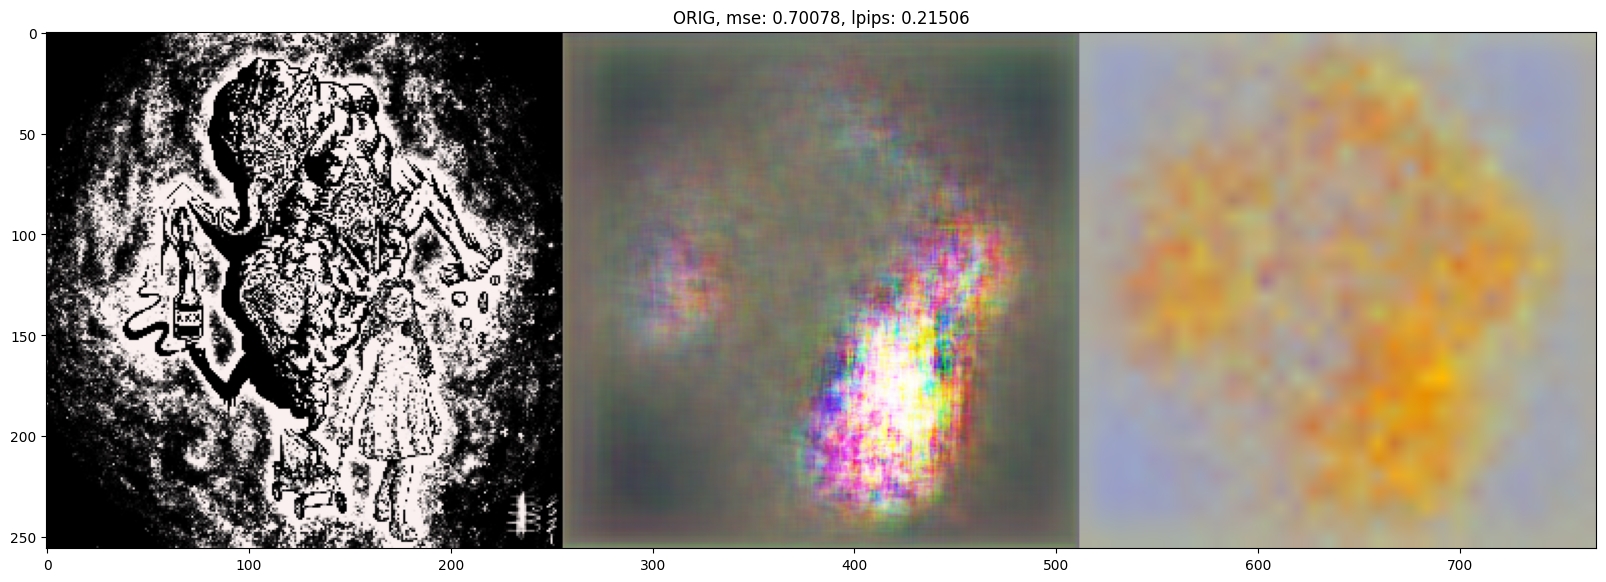

000005/027292 | 008/008 loss: 0.52826793417334563

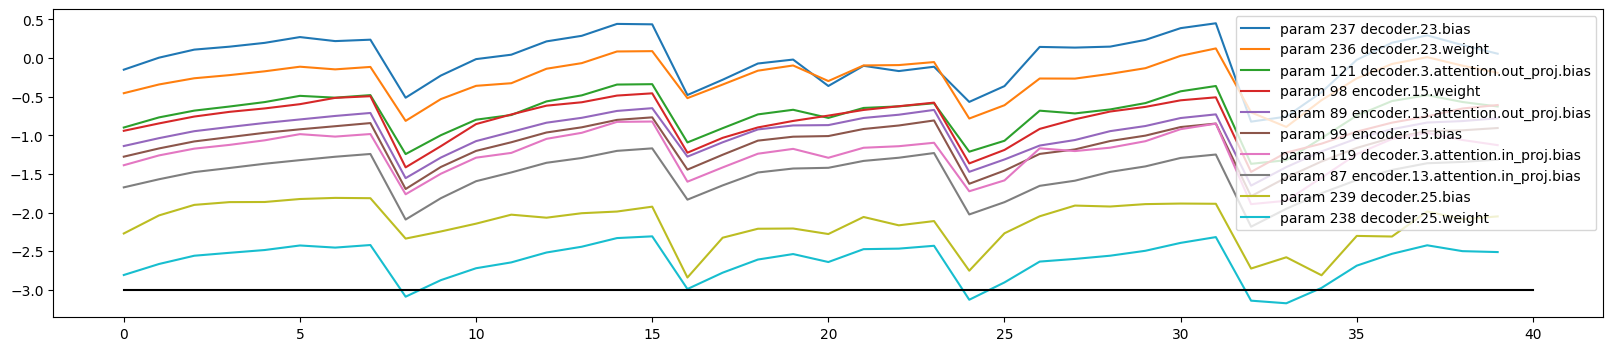

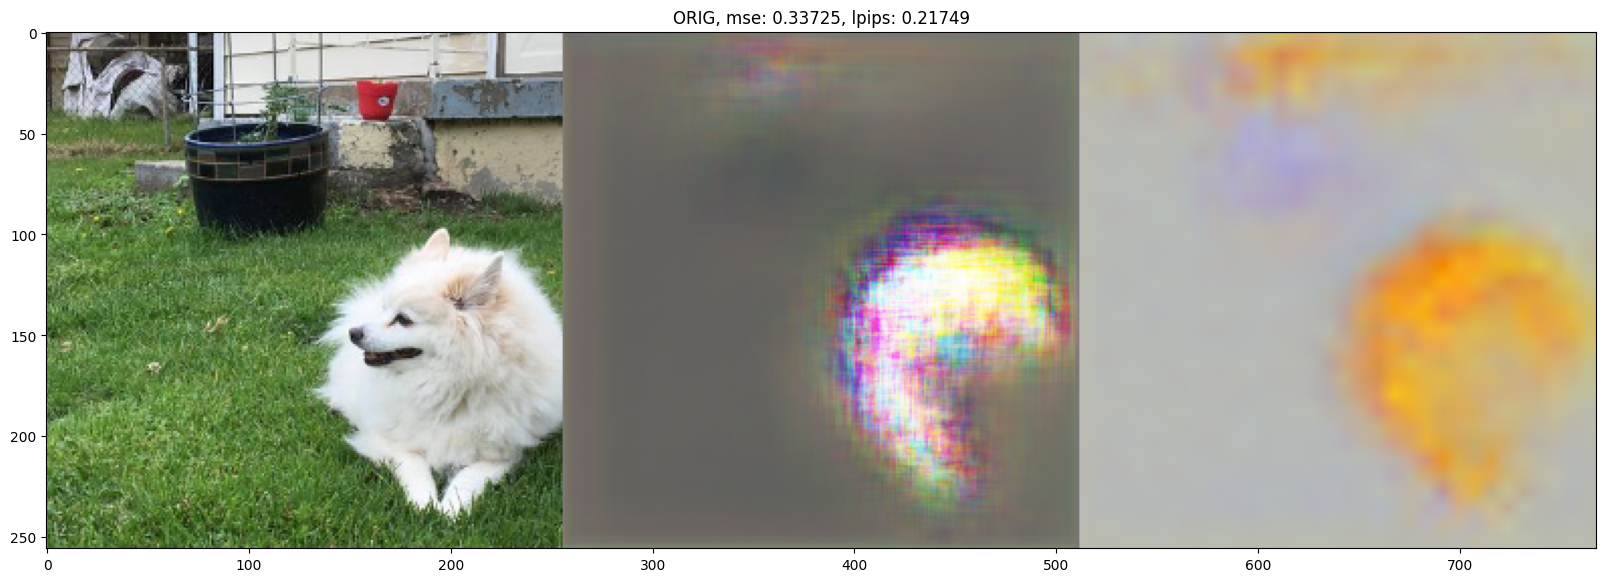


000010/027292 | 008/008 loss: 0.40954251050949165

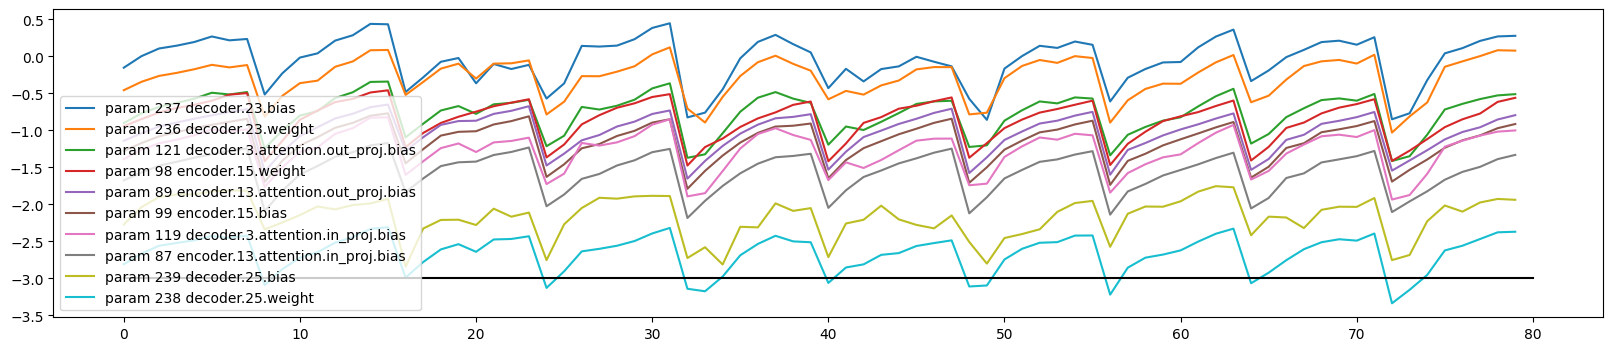

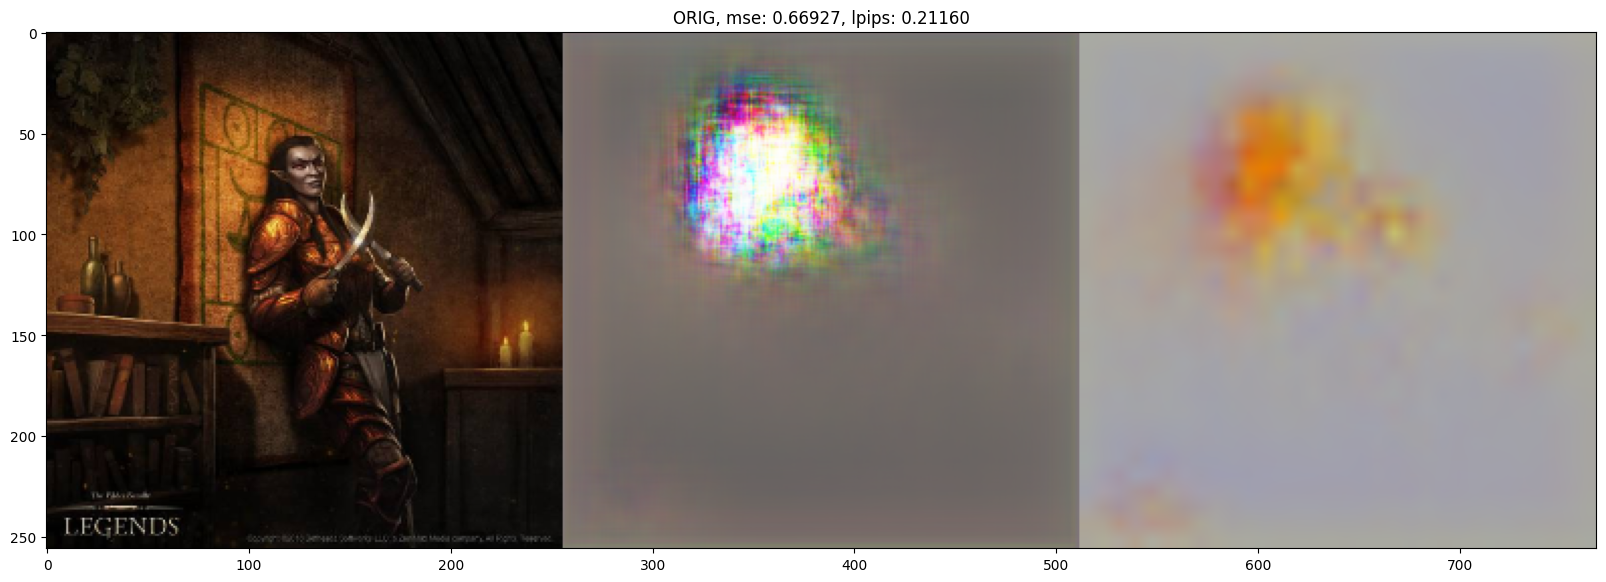


000011/027292 | 004/008 loss: 0.14277194866112332

KeyboardInterrupt: 

In [18]:
while True:
    try:
        n_epoch = 0
        for n_epoch in range(n_epoch, N_EPOCHS):
            print(f"{n_epoch + 1}|{N_EPOCHS}")
            show(N=1, M=1)
            train()
            eval(test_loader)
            torch.save(model.state_dict(), FILE_NAME_AUTOENCODER)
            torch.save(model.encoder.state_dict(), FILE_NAME_ENCODER)
            torch.save(model.decoder.state_dict(), FILE_NAME_DECODER)
            if REFINE:
                torch.save(model.refiner.state_dict(), FILE_NAME_REFINER)
    except Exception as e:
        print(e)
        n_epoch = 0
        torch.save(model.state_dict(), FILE_NAME_AUTOENCODER)
        torch.save(model.encoder.state_dict(), FILE_NAME_ENCODER)
        torch.save(model.decoder.state_dict(), FILE_NAME_DECODER)
        if REFINE:
            torch.save(model.refiner.state_dict(), FILE_NAME_REFINER)

In [ ]:
torch.save(model.state_dict(), FILE_NAME_AUTOENCODER)
torch.save(model.encoder.state_dict(), FILE_NAME_ENCODER)
torch.save(model.decoder.state_dict(), FILE_NAME_DECODER)
if REFINE:
    torch.save(model.refiner.state_dict(), FILE_NAME_REFINER)